## Module 3 Final Project Submission - Machine Learning with Mushrooms
* Student name: Emily J. Cain
* Student pace: full time
* Scheduled project review date/time: January 11, 2019
* Instructor name: Rafael Carrasco
* Blog post URL:

## Data Information
* Source: Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science
* Origin: Mushroom records drawn from The Audubon Society Field Guide to North American Mushrooms (1981). G. H. Lincoff (Pres.), New York: Alfred A. Knopf 
* Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)

## Description
This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525). Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous one. The Guide clearly states that there is no simple rule for determining the edibility of a mushroom; no rule like 'leaflets three, let it be' for Poisonous Oak and Ivy.

## Features
1. cap-shape
 * bell = b
 * conical = c
 * convex = x
 * flat = f 
 * knobbed = k
 * sunken = s 
2. cap-surface
 * fibrous = f
 * grooves = g
 * scaly = y
 * smooth = s 
3. cap-color 
 * brown = n
 * buff = b
 * cinnamon = c
 * gray = g
 * green = r
 * pink = p
 * purple = u
 * red = e
 * white = w
 * yellow = y 
4. bruises? 
 * true = t
 * false = f 
5. odor
 * almond = a
 * anise = l
 * creosote = c
 * fishy = y
 * foul = f
 * musty = m
 * none = n
 * pungent = p
 * spicy = s 
6. gill-attachment
 * attached = a
 * descending = d
 * free = f
 * notched = n 
7. gill-spacing
 * close = c
 * crowded = w
 * distant = d 
8. gill-size
 * broad = b
 * narrow = n 
9. gill-color
 * black = k
 * brown = n
 * buff = b
 * chocolate = h
 * gray = g
 * green = r
 * orange = o
 * pink = p
 * purple = u
 * red = e
 * white = w
 * yellow = y 
10. stalk-shape
 * enlarging = e
 * tapering = t 
11. stalk-root
 * bulbous = b
 * club = c
 * cup = u
 * equal = e
 * rhizomorphs = z
 * rooted = r
 * missing = ? 
12. stalk-surface-above-ring 
 * fibrous = f
 * scaly = y
 * silky = k
 * smooth = s 
13. stalk-surface-below-ring
 * fibrous = f
 * scaly = y
 * silky = k
 * smooth = s 
14. stalk-color-above-ring
 * brown = n
 * buff = b
 * cinnamon = c
 * gray = g
 * orange = o
 * pink = p
 * red = e
 * white = w
 * yellow = y 
15. stalk-color-below-ring
 * brown = n
 * buff = b
 * cinnamon = c
 * gray = g
 * orange = o
 * pink = p
 * red = e
 * white = w
 * yellow = y 
16. veil-type
 * partial = p
 * universal = u 
17. veil-color
 * brown = n
 * orange = o
 * white = w
 * yellow = y 
18. ring-number
 * none = n
 * one = o
 * two = t 
19. ring-type
 * cobwebby = c
 * evanescent = e
 * flaring = f
 * large = l
 * none = n
 * pendant = p
 * sheathing = s
 * zone = z 
20. spore-print-color
 * black = k
 * brown = n
 * buff = b
 * chocolate = h
 * green = r
 * orange = o
 * purple = u
 * white = w
 * yellow = y 
21. population
 * abundant = a
 * clustered = c
 * numerous = n
 * scattered = s
 * several = v
 * solitary = y 
22. habitat
 * grasses = g
 * leaves = l
 * meadows = m
 * paths = p
 * urban = u
 * waste = w
 * woods = d

## Targets
1. poisonous = p
2. edible = e

In [1]:
# Notes to self
# Extra: Can I turn the features into a table / something that isn't so long?
# Correlation heatmap or matrix? that does not seem useful or interpretable
# EDA?

In [22]:
import pandas as pd
import numpy as np
import time

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [14]:
df = pd.read_csv('mushrooms.csv')

In [3]:
df.head()

,edible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_cover_above_ring,stalk_cover_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


### Data Cleaning, Preprocessing, and Exploratory Data Analysis

In [6]:
df.describe()

,edible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_cover_above_ring,stalk_cover_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


#### Inspect the data for null, placeholder, and extreme outlier variables

In [7]:
df.isna().sum()

edible                      0
cap_shape                   0
cap_surface                 0
cap_color                   0
bruises                     0
odor                        0
gill_attachment             0
gill_spacing                0
gill_size                   0
gill_color                  0
stalk_shape                 0
stalk_root                  0
stalk_surface_above_ring    0
stalk_surface_below_ring    0
stalk_cover_above_ring      0
stalk_cover_below_ring      0
veil_type                   0
veil_color                  0
ring_number                 0
ring_type                   0
spore_print_color           0
population                  0
habitat                     0
dtype: int64

In [15]:
# for col in df.columns:
    # print(f'Unique values for {col}: {df[col].value_counts()}')

#### The stalk_root column appears to be the only column with a placeholder value

In [4]:
df.stalk_root.value_counts()

b    3776
?    2480
e    1120
c     556
r     192
Name: stalk_root, dtype: int64

#### With 2480 missing values and a potential life-or-death situation, the stalk_root column will be dropped from the dataset.

In [15]:
df = df.drop('stalk_root', axis=1)

In [13]:
df.head()

,edible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_cover_above_ring,stalk_cover_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [5]:
df.dtypes

edible                      object
cap_shape                   object
cap_surface                 object
cap_color                   object
bruises                     object
odor                        object
gill_attachment             object
gill_spacing                object
gill_size                   object
gill_color                  object
stalk_shape                 object
stalk_surface_above_ring    object
stalk_surface_below_ring    object
stalk_cover_above_ring      object
stalk_cover_below_ring      object
veil_type                   object
veil_color                  object
ring_number                 object
ring_type                   object
spore_print_color           object
population                  object
habitat                     object
dtype: object

In [16]:
target = df.edible
features = df.drop('edible', axis=1)

In [7]:
target.shape

(8124,)

In [8]:
features.shape

(8124, 21)

In [17]:
# Change target values - poisonous to 0, edible to 1
target = target.replace({'p': 0, 'e': 1})

In [18]:
target.dtypes

dtype('int64')

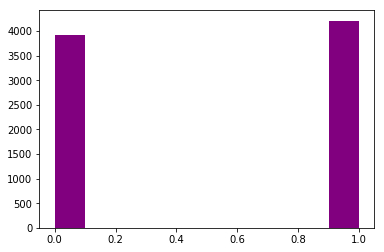

In [19]:
plt.hist(target, color='purple');

A fairly even distribution of edible to poisonous mushrooms does not indicate the need to weight target values. 

#### Change all categorical features to dummy variables

In [20]:
features = pd.get_dummies(features)

In [25]:
features.head()

,cap_shape_b,cap_shape_c,cap_shape_f,cap_shape_k,cap_shape_s,cap_shape_x,cap_surface_f,cap_surface_g,cap_surface_s,cap_surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=31)

In [30]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [31]:
y_preds = dt.predict(X_test)

In [38]:
print('Vanilla Decision Tree Scores')
print('*'*25)
print(f'Accuracy score: {accuracy_score(y_test, y_preds)}')
print(f'Classification Report: {classification_report(y_test, y_preds)}')

Vanilla Decision Tree Scores
*************************
Accuracy score: 1.0
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       960
           1       1.00      1.00      1.00      1071

   micro avg       1.00      1.00      1.00      2031
   macro avg       1.00      1.00      1.00      2031
weighted avg       1.00      1.00      1.00      2031



## Stuff I am Not Using

#### Check for multicollinearity with correlation heatmap - which is not useful

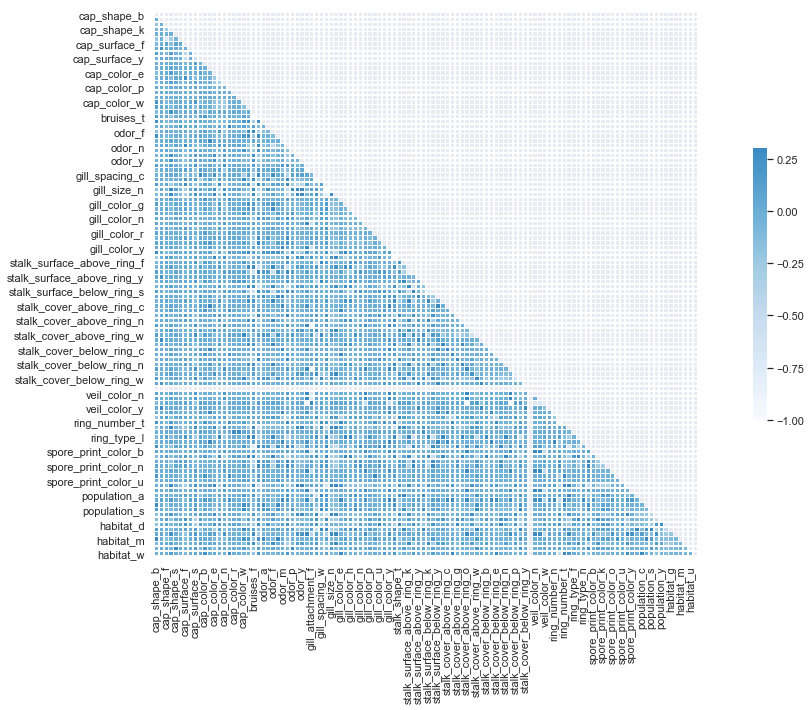

In [24]:
sns.set(style='dark')
corr = features.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(20,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap='Blues', vmax=0.3, center=0, square=True, linewidth=0.5, cbar_kws={'shrink': 0.5});

#### Check distributions of feature variables

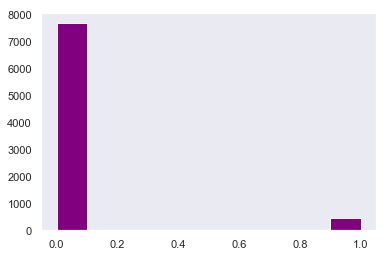

In [28]:
plt.hist(features.cap_shape_b, color='purple');